In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

### 1. Read in data

In [6]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


- This dataset contains daily weather observations, such as temperature, wind direction and humidity, from different locations in Australia. 
- Target of this project is to predict whether or not it will rain tomorrow. The target column is 'RainTomorrow'.
- This is a supervised learning project since we have clear target values.

In [31]:
df = df.replace({'RainTomorrow':{'No':0, 
                            'Yes':1}})

In [5]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

- We need to drop the column 'RISK_MM' which is the amount of precipitation in millimeters for the next day. 'RISK_MM' is used to actually determine whether or not it will rain in the next day. If 'RISK_MM' is greater than 0, then 'RainTomorrow' will be 'Yes'. Since 'RISK_MM' is directly related to the target column 'RainTomorrow', including 'RISK_MM' would leak the future information to the model we build and give a false appearance of high accuracy.
- 'Date' and 'Location' are not useful features in training a model, so we drop them as well.


In [8]:
df = df.drop(['Date','Location','RISK_MM'], axis=1)

### 2. Exploratory analysis

In [7]:
df.shape

(142193, 24)

The dataset has 142,193 samples and 24 columns.

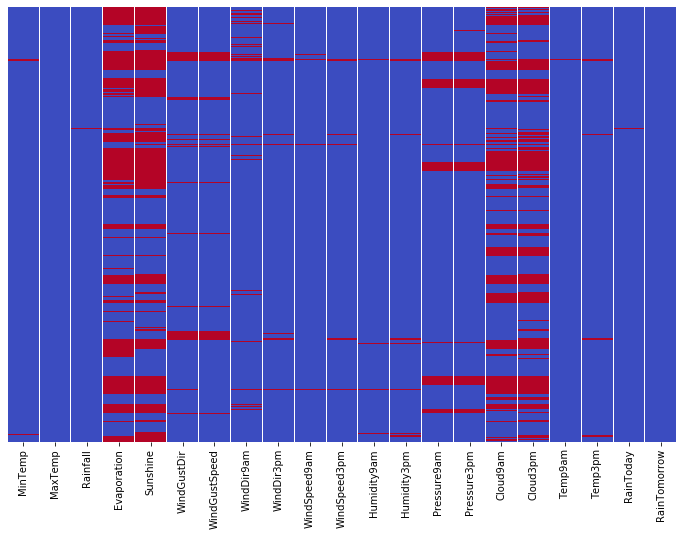

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False)

- 'Red' color indicates missing values.
- 'Evaporation', 'Sunshine', 'Cloud9am' and 'Cloud3pm' columns contain more missing values than other columns

In [21]:
print ('50% of total samples:', 0.5*df.shape[0])
df.isnull().sum()

50% of total samples: 71096.5


MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

- None of the columns has 'NaN' more than half of the total number of samples. We can fill in the missing values with mean or mode of each column.
- For columns with float values, we can fill in missing values with mean.
- For categorical features, we can fill in missing values with mode.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 21 columns):
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null object
RainTomorrow     142193 non-null int64
dtypes: float64(16), int64(1), object(

In [57]:

yes = df[df.RainTomorrow == 1]
no = df[df.RainTomorrow == 0]


In [60]:
for c in df.columns:
    yes_mode = yes[c].mode()[0]
    yes[c] = yes[c].fillna(value=yes_mode)
    no_mode = no[c].mode()[0]
    no[c] = no[c].fillna(value=no_mode)
    column = pd.concat([yes[c],no[c]])
    df[c]=column

C:\Users\yuzij\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yuzij\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Encode categorical features with one-hot encoding and binary variables.

In [64]:
windgustdir = pd.get_dummies(df['WindGustDir'], prefix='WGD')
df = pd.concat([df.drop(['WindGustDir'],axis=1), windgustdir] ,axis=1)



In [65]:
winddir9 = pd.get_dummies(df['WindDir9am'], prefix='WD9')
df = pd.concat([df.drop(['WindDir9am'],axis=1), winddir9] ,axis=1)

In [66]:
winddir3 = pd.get_dummies(df['WindDir3pm'], prefix='WD3')
df = pd.concat([df.drop(['WindDir3pm'],axis=1), winddir3] ,axis=1)

In [67]:
df = df.replace({'RainToday':{'Yes':1,
                             'No':0}})

### Logistic regression

In [72]:
X = df.drop('RainTomorrow', axis=1).values
y = df.RainTomorrow

Normalize data before training with logistic regression model.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

- Use cross validation to generalize results.
- Hyperparameter tuning.

In [90]:
accuracy_train=[]
accuracy_test=[]
for l in ['l1', 'l2']:  
    print ('penalty = ',l)
    acc_train_list=[]
    acc_test_list=[]
    for c in [0.001, 0.01, 0.1, 1, 10]:
        LR = LogisticRegression(penalty=l, C=c, solver='saga')
        #scores = cross_val_score(clf, X, y, cv=5)
        acc1 = cross_val_score(LR, X_train, y_train, cv=10)
        acc2 = LR.score(X_test, y_test)
        acc_train_list.append(np.array(acc1).mean())
        acc_test_list.append(acc2)
        print ('C = {}, average accuracy = {}'.format(c, round(np.array(acc1).mean(),4)))
    accuracy_train.append(acc_train_list)
    accuracy_test.append(acc_test_list)

penalty =  l1
C = 0.001, average accuracy = 0.9245
C = 0.01, average accuracy = 0.9322
C = 0.1, average accuracy = 0.9329
C = 1, average accuracy = 0.933
C = 10, average accuracy = 0.933
penalty =  l2
C = 0.001, average accuracy = 0.9302
C = 0.01, average accuracy = 0.9327
C = 0.1, average accuracy = 0.9329
C = 1, average accuracy = 0.933
C = 10, average accuracy = 0.933


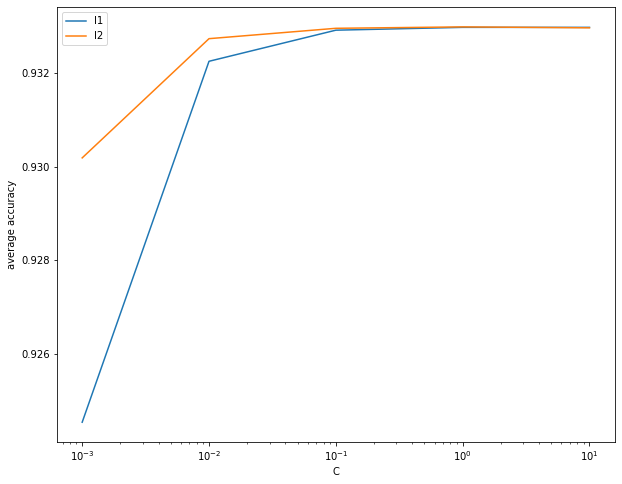

In [92]:
C = [0.001, 0.01, 0.1, 1, 10]
plt.figure(figsize=(10,8))
plt.plot(C, accuracy_train[0], 'r', '-', label='l1-train')
plt.plot(C, accuracy_train[1], 'b', '-', label='l2-train')
plt.plot(C, accuracy_test[0], 'r', '--', label='l1-test')
plt.plot(C, accuracy_test[1], 'b', '--', label='l2-test')
plt.semilogx()
plt.xlabel('C')
plt.ylabel('average accuracy')
plt.legend()

#### Fine tuning

In [95]:
C_list = list(np.arange(0.5,5,0.5))
acc_list=[]
for c in C_list:
    LR = LogisticRegression(penalty='l2', C=c, solver='saga')
    #scores = cross_val_score(clf, X, y, cv=5)
    acc = cross_val_score(LR, X_train, y_train, cv=10)
    acc_list.append(np.array(acc).mean())
    print ('C = {}, average accuracy = {}'.format(round(c,1), round(np.array(acc).mean(),4)))  

C = 0.5, average accuracy = 0.933
C = 1.0, average accuracy = 0.933
C = 1.5, average accuracy = 0.933
C = 2.0, average accuracy = 0.933
C = 2.5, average accuracy = 0.933
C = 3.0, average accuracy = 0.933
C = 3.5, average accuracy = 0.933
C = 4.0, average accuracy = 0.933
C = 4.5, average accuracy = 0.933


No handles with labels found to put in legend.


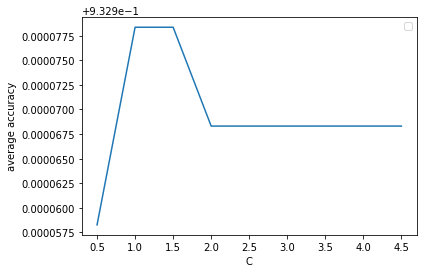

In [96]:
plt.plot(C_list, acc_list)
plt.xlabel('C')
plt.ylabel('average accuracy')
plt.legend()

- Highest accuracy is achieved at C=1 and C=1.5
- However, the accuracy values are very close for varying C. There is almost no change.

#### Feature importance
The feature that has higher absolute coefficient value is more important in prediction.

In [97]:
LR = LogisticRegression(penalty='l2', C=1, solver='saga')
LR.fit(X_train, y_train)

<bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)>

In [141]:
feature_importance = pd.DataFrame({'feature':list(df.drop('RainTomorrow',axis=1).columns),
                                  'coefficient':LR.coef_.tolist()[0],
                                  'abs_value':abs(LR.coef_).tolist()[0]})
feature_importance.sort_values(by='abs_value', ascending=False).head(10)

,feature,coefficient,abs_value
0,MinTemp,-1.915668,1.915668
4,Sunshine,-1.541962,1.541962
11,Pressure3pm,-1.319462,1.319462
15,Temp3pm,1.151812,1.151812
9,Humidity3pm,1.025751,1.025751
14,Temp9am,0.994384,0.994384
10,Pressure9am,0.825342,0.825342
1,MaxTemp,-0.797424,0.797424
13,Cloud3pm,0.755454,0.755454
5,WindGustSpeed,0.564720,0.564720


The top 10 features with high importance are 
- minimum temperature and maximum temperature in a day
- sunshine 
- pressure, temperature, humidity, cloud at 3pm
- temperature, pressure at 9am
- wind gust speed